<a href="https://colab.research.google.com/github/Battlehooks/Battlehooks/blob/main/My_own_AutoReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('seaborn-darkgrid')
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
data = pd.read_csv('/content/data.csv',index_col = 'DateTime', parse_dates = ['DateTime'], infer_datetime_format = True)
data = data.reindex(pd.date_range(data.index[0], data.index[-1]), method = 'pad').squeeze()
data

2019-02-13    593000
2019-02-14    593000
2019-02-15    595000
2019-02-16    595000
2019-02-17    595000
               ...  
2022-02-05    883000
2022-02-06    883000
2022-02-07    883000
2022-02-08    883000
2022-02-09    877000
Freq: D, Name: Harga Emas, Length: 1093, dtype: int64

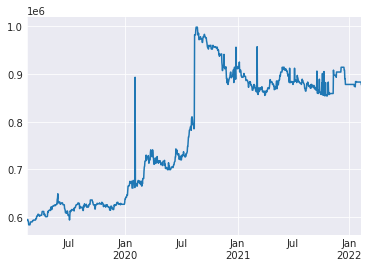

In [3]:
data.plot.line()

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, HuberRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import KFold
from datetime import datetime, timedelta
from tqdm.auto import tqdm

def make_lags(ts, lags = 0) :
    return pd.concat({
        f'lag_{i}' : ts.shift(i)
        for i in range(lags + 1)
    }, axis = 1)

def make_steps(ts, steps = 1) :
    return pd.concat({
        f'fore_{i}' : ts.shift(-i)
        for i in range(1, steps + 1)
    }, axis = 1)

def AutoReg(ts, steps, *, lags = 0, estimator = LinearRegression(), method = None) :
    origin = make_lags(ts, lags = lags).dropna()
    forecast = make_steps(ts, steps = steps).dropna()
    y, x = forecast.align(origin, join = 'inner', axis = 0)
    methods = ['recursive', 'direct', None, 'dirrec']
    model = estimator
    if not method in methods : 
        raise TypeError(f'{method} is not in {methods}')
    if method == 'dirrec' :
        model = RegressorChain(estimator)
    if method == 'direct' :
        model = MultiOutputRegressor(estimator)
    if method == 'recursive' :
        def recursive(ts, estimator, steps) :
            for i in range(1, steps+1) :
                x = ts.to_frame()
                y = ts.shift(-1).dropna()
                y, x = y.align(x, join = 'inner', axis = 0)
                model.fit(x, y)
                preds = pd.Series(
                    model.predict(ts.to_frame())
                ).iloc[-1]
                preds = pd.Series(
                    preds, index = [ts.index[-1] + timedelta(days = 1)]
                )
                ts = ts.append(preds)
            return ts.iloc[-steps:].values
        return recursive(ts, estimator, steps)
    model.fit(x, y)
    ypred = pd.DataFrame(
        model.predict(origin), index = origin.index, columns = forecast.columns
    ).iloc[-1, :]
    return ypred.values

In [5]:
data = data.loc['2021':]
data

2021-01-01    911000
2021-01-02    911000
2021-01-03    912000
2021-01-04    912000
2021-01-05    914000
               ...  
2022-02-05    883000
2022-02-06    883000
2022-02-07    883000
2022-02-08    883000
2022-02-09    877000
Freq: D, Name: Harga Emas, Length: 405, dtype: int64

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from warnings import filterwarnings, simplefilter
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
filterwarnings('ignore')
simplefilter('ignore')
train, val = train_test_split(data, test_size = .3, shuffle = False)
display(train, val)

2021-01-01    911000
2021-01-02    911000
2021-01-03    912000
2021-01-04    912000
2021-01-05    914000
               ...  
2021-10-06    856000
2021-10-07    863000
2021-10-08    856000
2021-10-09    856000
2021-10-10    905000
Freq: D, Name: Harga Emas, Length: 283, dtype: int64

2021-10-11    856000
2021-10-12    855000
2021-10-13    854000
2021-10-14    862000
2021-10-15    882000
               ...  
2022-02-05    883000
2022-02-06    883000
2022-02-07    883000
2022-02-08    883000
2022-02-09    877000
Freq: D, Name: Harga Emas, Length: 122, dtype: int64

In [10]:
grid = {
    'method' : ['direct', 'dirrec', None, 'recursive'],
    'lags' : list(range(1, 100)),
    'estimator' : [LinearRegression(), DecisionTreeRegressor(max_depth = 3)]
}
print(list(ParameterGrid(grid)))

[{'estimator': LinearRegression(), 'lags': 1, 'method': 'direct'}, {'estimator': LinearRegression(), 'lags': 1, 'method': 'dirrec'}, {'estimator': LinearRegression(), 'lags': 1, 'method': None}, {'estimator': LinearRegression(), 'lags': 1, 'method': 'recursive'}, {'estimator': LinearRegression(), 'lags': 2, 'method': 'direct'}, {'estimator': LinearRegression(), 'lags': 2, 'method': 'dirrec'}, {'estimator': LinearRegression(), 'lags': 2, 'method': None}, {'estimator': LinearRegression(), 'lags': 2, 'method': 'recursive'}, {'estimator': LinearRegression(), 'lags': 3, 'method': 'direct'}, {'estimator': LinearRegression(), 'lags': 3, 'method': 'dirrec'}, {'estimator': LinearRegression(), 'lags': 3, 'method': None}, {'estimator': LinearRegression(), 'lags': 3, 'method': 'recursive'}, {'estimator': LinearRegression(), 'lags': 4, 'method': 'direct'}, {'estimator': LinearRegression(), 'lags': 4, 'method': 'dirrec'}, {'estimator': LinearRegression(), 'lags': 4, 'method': None}, {'estimator': Li

In [ ]:
hp = list(ParameterGrid(grid))
scores = []
for p in tqdm(hp) :
    #print(p)
    yhat = AutoReg(
        train, len(val), lags = p['lags'], estimator = p['estimator'], method = p['method']
    )
    yhat = pd.Series(
        yhat, index = val.index
    )
    score = mean_absolute_error(val, yhat)
    scores.append(score)
    #print(score)
    #val.plot.line(color = 'blue')
    #yhat.plot.line(color = 'red')
    #plt.show()
    #print('')
print('Best Param Grid :', hp[np.argmin(scores)], 'with score of', scores[np.argmin(scores)])

  0%|          | 0/792 [00:00<?, ?it/s]

In [ ]:
x = make_lags(data, 2).dropna()
y = make_steps(data, 3).dropna()
y, x = y.align(x, join = 'inner', axis = 0)
model = MultiOutputRegressor(LinearRegression()).fit(x, y)

In [ ]:
print(yhat)

In [ ]:
data